In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import math
import pmdarima as pm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [326]:
df = yf.download("^GSPC", start = "2010-01-01", end = "2023-01-01")

[*********************100%***********************]  1 of 1 completed


In [327]:
df['diff'] = df['Adj Close'].diff()
df = df.dropna()

df['diff']

Date
2010-01-05     3.530029
2010-01-06     0.619995
2010-01-07     4.549927
2010-01-08     3.290039
2010-01-11     2.000000
                ...    
2022-12-23    22.430176
2022-12-27   -15.570068
2022-12-28   -46.030029
2022-12-29    66.060059
2022-12-30    -9.780029
Name: diff, Length: 3271, dtype: float64

In [328]:
results = adfuller(df['diff'])
t_stat = results[0]

print(f't-stat : {t_stat}')
for key, values in results[4].items():
    print(key, values)
    print(t_stat < values)

t-stat : -11.983158416094996
1% -3.4323674112281393
True
5% -2.8624313714499374
True
10% -2.5672444962719756
True


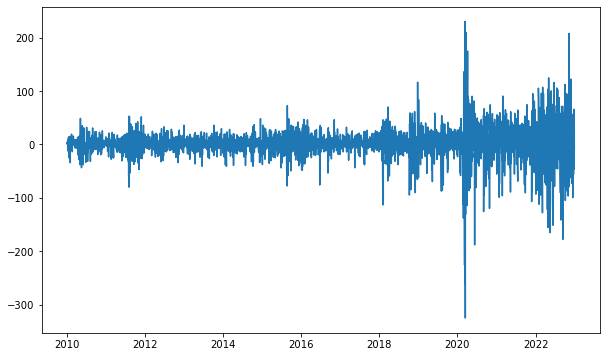

In [421]:
plt.figure(figsize = (10,6))
plt.plot(df['diff'])

# Split Train and Test data

In [329]:
def test(df, pct): #how many pct from all data you want testing_data to be [out-sample] 
    to_row = int(len(df)*(1-(pct/100)))
    training_data = list(df[:to_row]['Adj Close'])
    testing_data = list(df[to_row:]['Adj Close'])
    return to_row, training_data, testing_data

In [330]:
to_row, training_data, testing_data = test(df, 20)

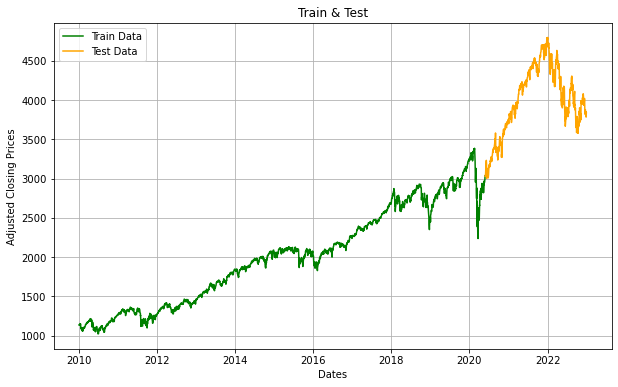

In [331]:
#plot splitted data

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Adjusted Closing Prices')
plt.plot(df[:to_row]['Adj Close'], 'green', label='Train Data')
plt.plot(df[to_row:]['Adj Close'], 'orange', label='Test Data')
plt.title('Train & Test')
plt.legend()

# Forecast Model 1: ACF, PACF, ARIMA

In [286]:
bestOrder = pm.auto_arima(df['Adj Close'],  information_criterion='aic')

In [287]:
bestOrder

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

### proof

C:\Users\ateet\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


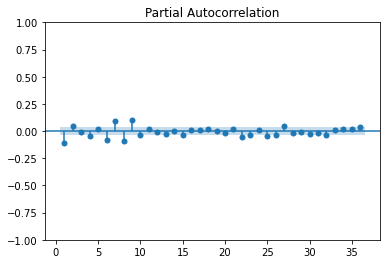

In [332]:
plot_pacf(df['diff'], zero = False);

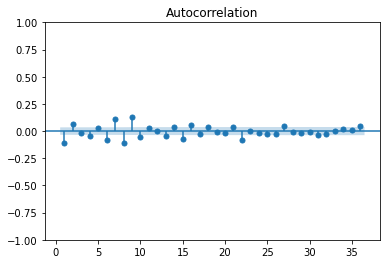

In [333]:
plot_acf(df['diff'], zero = False);

# Model Prediction

In [334]:
model_predictions = []
n_test_obser = len(testing_data)

In [335]:
for i in range(n_test_obser):
    model = ARIMA(training_data, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    actual_test_value = testing_data[i]
    training_data.append(actual_test_value)

C:\Users\ateet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [336]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3270
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -15694.973
Date:                Wed, 22 Mar 2023   AIC                          31399.946
Time:                        13:45:55   BIC                          31430.408
Sample:                             0   HQIC                         31410.856
                               - 3270                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7523      0.013   -135.217      0.000      -1.778      -1.727
ar.L2         -0.8808      0.012    -72.259      0.000      -0.905      -0.857
ma.L1          1.6722      0.016    101.415      0.0

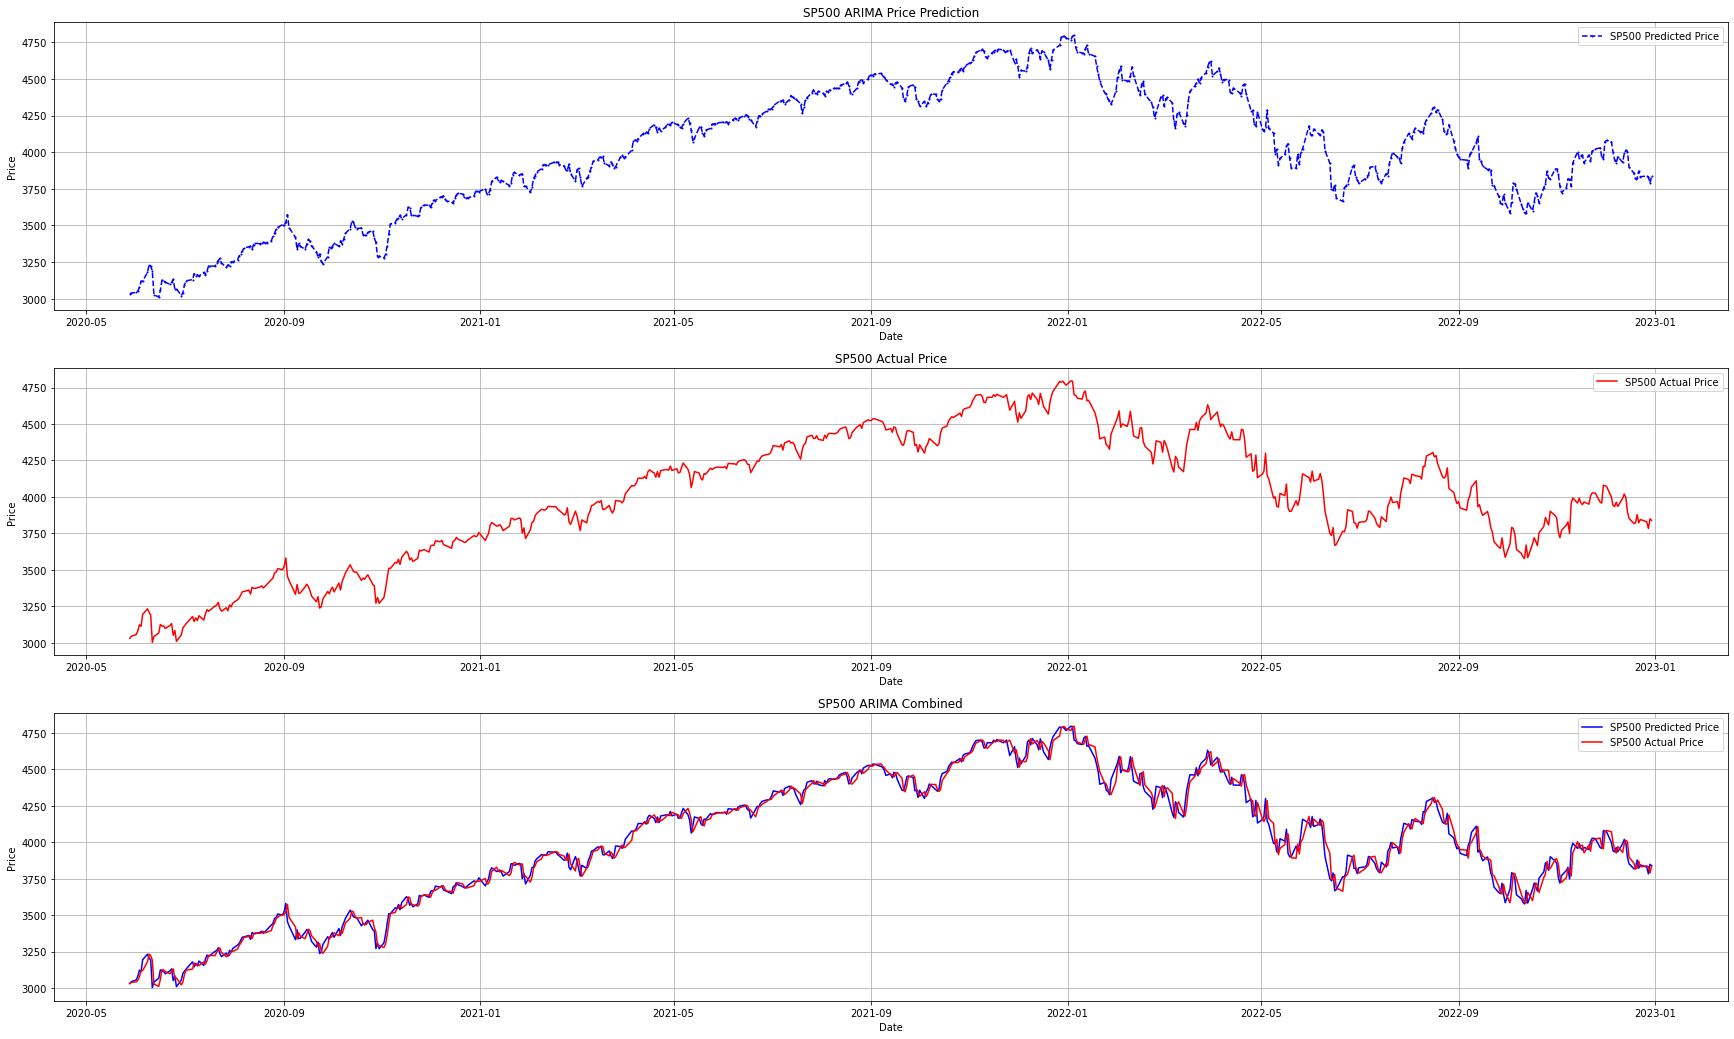

In [423]:
fig, ax = plt.subplots(3,1,figsize=(30,18))

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

date_range = df[to_row:].index

ax[0].plot(date_range, model_predictions, color = 'blue', marker = 'o', markersize = 1, linestyle = 'dashed', label = 'SP500 Predicted Price')
#ax.plot(date_range, testing_data, color = 'red', label = 'DJI Actual Price')

ax[0].set_title('SP500 ARIMA Price Prediction')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price')
ax[0].legend()

ax[1].plot(date_range, testing_data, color = 'red', label = 'SP500 Actual Price')

ax[1].set_title('SP500 Actual Price')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price')
ax[1].legend()

ax[2].plot(date_range, testing_data, color = 'blue', label = 'SP500 Predicted Price')
ax[2].plot(date_range, model_predictions, color = 'red', label = 'SP500 Actual Price')

ax[2].set_title('SP500 ARIMA Combined')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Price')
ax[2].legend()

In [399]:
lstModel1 = []

for i in df['Adj Close'][:to_row]:
    lstModel1.append(i) # In Sample
    
for j in model_predictions:
    lstModel1.append(j) # In + Out Sample
    

In [415]:
m1 = pd.DataFrame()
m1.index = df.index

m1['Adj Close'] = lstModel1

m1_out = pd.DataFrame()
m1_out.index = df.index[to_row:]

m1_out['Adj Close'] = model_predictions

print(pd.DataFrame(testing_data))
print(m1_out['Adj Close'])

               0
0    3029.729980
1    3044.310059
2    3055.729980
3    3080.820068
4    3122.870117
..           ...
650  3844.820068
651  3829.250000
652  3783.219971
653  3849.280029
654  3839.500000

[655 rows x 1 columns]
Date
2020-05-28    3032.930134
2020-05-29    3038.634652
2020-06-01    3042.457362
2020-06-02    3052.571026
2020-06-03    3078.289501
                 ...     
2022-12-23    3832.214143
2022-12-27    3838.097343
2022-12-28    3831.839063
2022-12-29    3789.434098
2022-12-30    3836.057157
Name: Adj Close, Length: 655, dtype: float64


# Forecaste Model 2 : Naive, Lag

In [276]:
to_row2, training_data2, testing_data2 = test(df, 20)

In [370]:
lstModel2 = []
m2Out = []

for i in df['Adj Close'][:to_row]:
    lstModel2.append(i) # In sample

for j in df['Adj Close'][to_row2-1:-1]:
    lstModel2.append(j) # In + Out Sample
    m2Out.append(j) # Out Sample

In [401]:
m2 = pd.DataFrame()
m2.index = df.index

m2['Adj Close'] = lstModel2

m2_out = pd.DataFrame()
m2_out.index = df.index[to_row2:]

m2_out['Adj Close'] = m2Out

print(pd.DataFrame(m2))
print(pd.DataFrame(m2_out))

              Adj Close
Date                   
2010-01-05  1136.520020
2010-01-06  1137.140015
2010-01-07  1141.689941
2010-01-08  1144.979980
2010-01-11  1146.979980
...                 ...
2022-12-23  3822.389893
2022-12-27  3844.820068
2022-12-28  3829.250000
2022-12-29  3783.219971
2022-12-30  3849.280029

[3271 rows x 1 columns]
              Adj Close
Date                   
2020-05-28  3036.129883
2020-05-29  3029.729980
2020-06-01  3044.310059
2020-06-02  3055.729980
2020-06-03  3080.820068
...                 ...
2022-12-23  3822.389893
2022-12-27  3844.820068
2022-12-28  3829.250000
2022-12-29  3783.219971
2022-12-30  3849.280029

[655 rows x 1 columns]


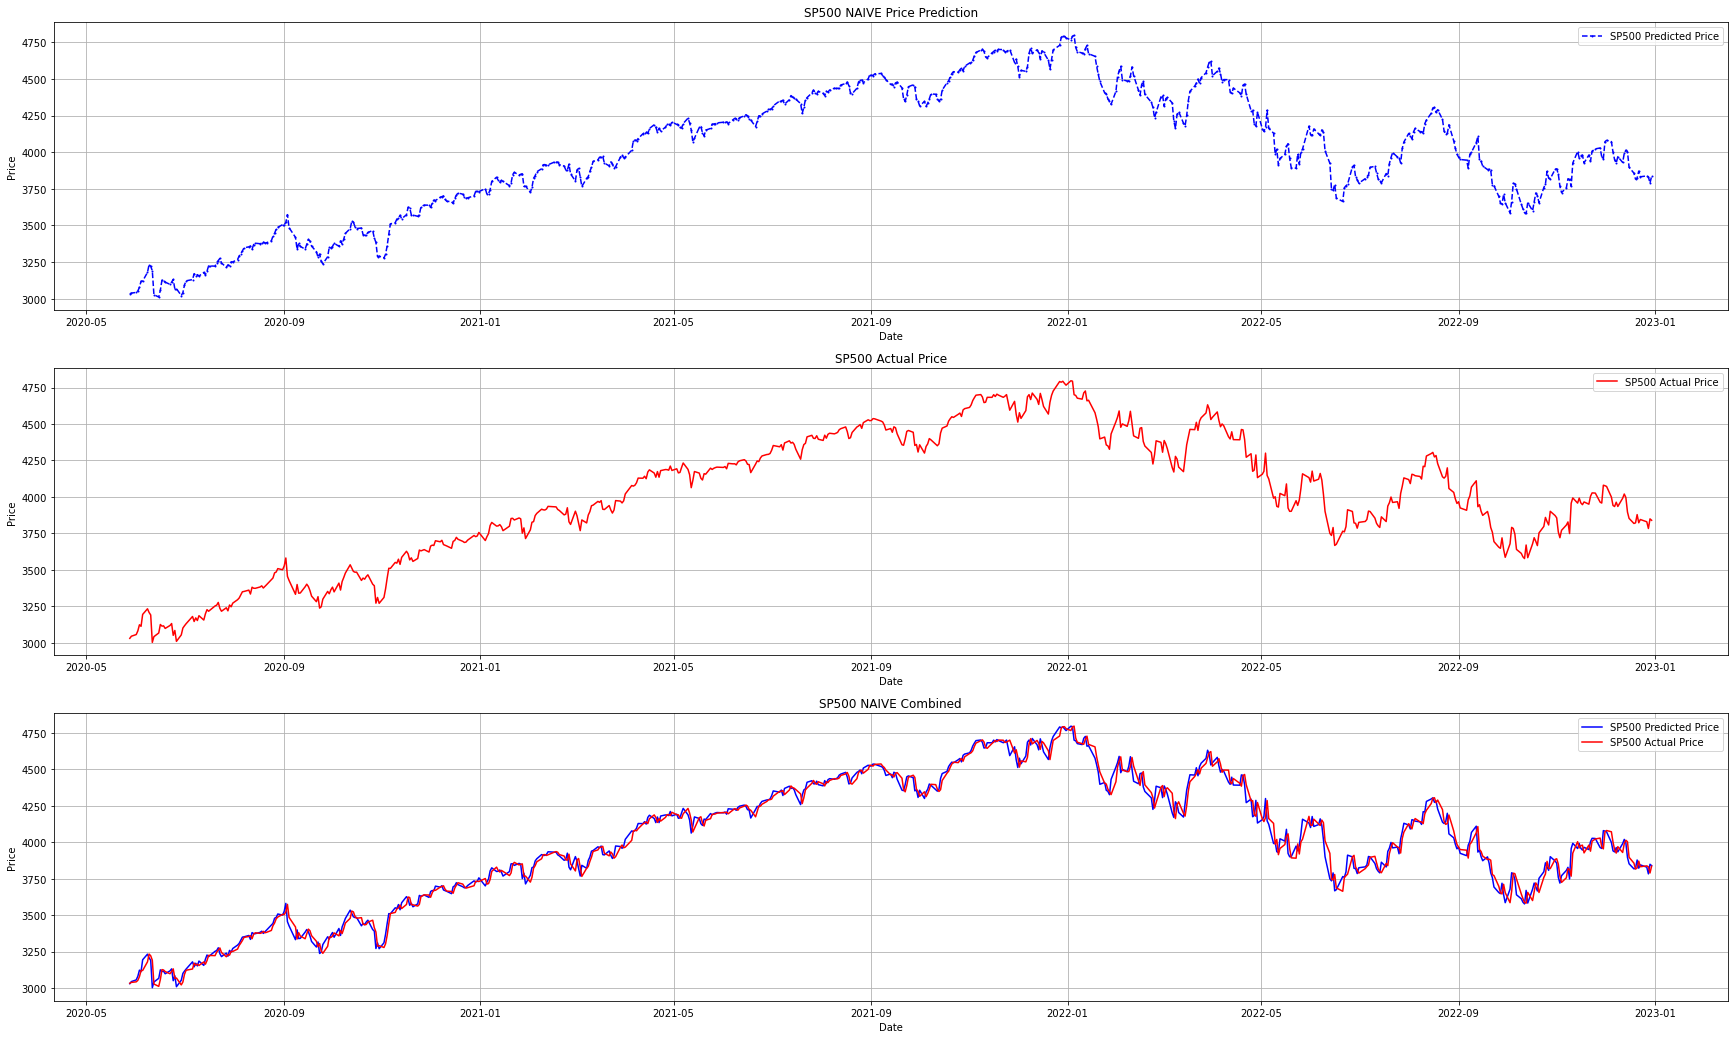

In [422]:
fig, ax = plt.subplots(3,1,figsize=(30,18))

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

date_range = df[to_row:].index

ax[0].plot(date_range, m1_out['Adj Close'], color = 'blue', marker = 'o', markersize = 1, linestyle = 'dashed', label = 'SP500 Predicted Price')
#ax.plot(date_range, testing_data, color = 'red', label = 'DJI Actual Price')

ax[0].set_title('SP500 NAIVE Price Prediction')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price')
ax[0].legend()

ax[1].plot(date_range, testing_data, color = 'red', label = 'SP500 Actual Price')

ax[1].set_title('SP500 Actual Price')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price')
ax[1].legend()

ax[2].plot(date_range, testing_data, color = 'blue', label = 'SP500 Predicted Price')
ax[2].plot(date_range, m1_out['Adj Close'], color = 'red', label = 'SP500 Actual Price')

ax[2].set_title('SP500 NAIVE Combined')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Price')
ax[2].legend()

# Strategies on F1 and F2 : MA, MACD, Bollinger Bands

In [386]:
    def ma_crossover(self, short_window, long_window,initial_investment):
        
        # Calculate the short-term and long-term moving averages
        self['SMA_short'] = self['Adj Close'].rolling(window=short_window).mean()
        self['SMA_long'] = self['Adj Close'].rolling(window=long_window).mean()

        # Generate buy and sell signals based on the MA crossover
        self['Signal'] = 0
        self['keepSignal'] = 0
        self['replicateSignal'] = 0
        self.loc[self['SMA_short'] > self['SMA_long'], 'Signal'] = 1
        self.loc[self['SMA_short'] < self['SMA_long'], 'Signal'] = -1
        
        for i in range(short_window, len(self)):
            if self['Signal'][i] != 0 :
                self.loc[self.index[i], 'replicateSignal'] = self['Signal'][i]
            else:
                self.loc[self.index[i], 'replicateSignal'] = self['replicateSignal'][i-1]
        
        # include only open signal into keepSignal
        for i in range(short_window, len(self)):   
            if self['Signal'][i] != self['Signal'][i-1]:
                self.loc[self.index[i], 'keepSignal'] = self['Signal'][i]

        # Track current position and trade details
        self['entry_date'] = pd.Series([np.nan]*len(self))
        self['entry_price'] = pd.Series([np.nan]*len(self))
        self['exit_date'] = pd.Series([np.nan]*len(self))
        self['exit_price'] = pd.Series([np.nan]*len(self))
        self['portfolioValue'] = pd.Series([np.nan]*len(self))
        self['trade_returns'] = pd.Series([np.nan]*len(self))
        entry_price = 0
        howManyPositionSoFar = 0
        portfolioValue = initial_investment
        whatisit = 0
        lstReturns = []

        for i in range(short_window, len(self)):
            # Check for trade entry signal
            if self['keepSignal'][i] != 0 and entry_price == 0:
                self.loc[self.index[i], 'entry_date'] = self.index[i]
                self.loc[self.index[i], 'entry_price'] = self['Adj Close'][i]
                self.loc[self.index[i], 'portfolioValue'] = portfolioValue
                entry_price = self['Adj Close'][i]
                howManyPositionSoFar += 1
                whatisit = self['keepSignal'][i]
                #print(f'Position number : {howManyPositionSoFar}')
                #print('Entry Date : ' + str(self['entry_date'][i]))
                #print('Entry Price : ' + str(self['entry_price'][i]))
                #print(f'Current Portfolio Value : {portfolioValue}')
                if whatisit == 1 :
                    #print('Enter Position With : BUY Order')
                    pass
                else : 
                    #print('Enter Position With : SELL Order')
                    pass
                #print('--------------------')
                
            elif self['keepSignal'][i] != 0 and entry_price != 0:
                self.loc[self.index[i], 'exit_date'] = self.index[i]
                self.loc[self.index[i], 'exit_price'] = self['Adj Close'][i]
                self.loc[self.index[i], 'entry_date'] = self.index[i]
                self.loc[self.index[i], 'entry_price'] = self['Adj Close'][i]
                howManyPositionSoFar += 1
                #print('Entry and Exit Date : ' + str(self['exit_date'][i]))
                
                # Calculate and plot cumulative returns for the closed trade
                # if buy
                if self['keepSignal'][i] == 1 : #from -1 --> 1
                    trade_returns = 1 - (self['exit_price'][i]/entry_price)
                    lstReturns.append(trade_returns*100)
                    self.loc[self.index[i], 'trade_returns'] = trade_returns*100
                    portfolioValue = (1 + trade_returns) * portfolioValue
                    if portfolioValue <= 0 :
                        portfolioValue = 0
                    self.loc[self.index[i], 'portfolioValue'] = portfolioValue
                    
                    #print(f'Close Position Number : {howManyPositionSoFar-1}')
                    #print(f'Previous Entry Price : {entry_price}')
                    #print('Exit Price : ' + str(self['exit_price'][i]))
                    #print(f'Profit : {trade_returns*100}%')
                    #print(f'Current Portfolio Value : {portfolioValue}')
                    
                    entry_price = self['exit_price'][i]
                    
                    #print(f'Open New Position Number : {howManyPositionSoFar}')
                    
                    whatisit = self['keepSignal'][i]
                    if whatisit == 1 :
                        #print('Enter Position With : BUY Order')
                        pass
                    else : 
                        #print('Enter Position With : SELL Order')
                        pass
                        
                    #print(f'At Entry Price : {entry_price}')
                    #print('--------------------')
                    
                else: #from 1 --> -1
                    trade_returns = (self['exit_price'][i] / entry_price) - 1
                    lstReturns.append(trade_returns*100)
                    self.loc[self.index[i], 'trade_returns'] = trade_returns*100
                    portfolioValue = (1 + trade_returns) * portfolioValue
                    if portfolioValue <= 0 :
                        portfolioValue = 0
                    self.loc[self.index[i], 'portfolioValue'] = portfolioValue
                    
                    #print(f'Close Position Number : {howManyPositionSoFar-1}')
                    #print(f'Previous Entry Price : {entry_price}')
                    #print('Exit Price : ' + str(self['exit_price'][i]))
                    #print(f'Profit : {trade_returns*100}%')
                    #print(f'Current Portfolio Value : {portfolioValue}')
                    
                    entry_price = self['exit_price'][i]
                    
                    #print(f'Open New Position Number : {howManyPositionSoFar}')
                    
                    whatisit = self['keepSignal'][i]
                    if whatisit == 1 :
                        #print('Enter Position With : BUY Order')
                        pass
                    else : 
                        #print('Enter Position With : SELL Order')
                        pass
                        
                    #print(f'At Entry Price : {entry_price}')
                    #print('--------------------')
                     
            self.loc[self.index[i], 'portfolioValue'] = portfolioValue
            #print(f' {symbol} date : {self.index[i]}')
            #print(f' {symbol} PortValue : ' + str(self['portfolioValue'][i]))
             
        # Plot the results
        fig, ax = plt.subplots(2,1, figsize=(20, 12))
        ax[0].plot(self['Adj Close'], label='Adjusted Close')
        ax[0].plot(self['SMA_short'], label='Short-term MA')
        ax[0].plot(self['SMA_long'], label='Long-term MA')
        ax[0].plot(self.loc[self['keepSignal'] == 1].index, self['Adj Close'][self['keepSignal'] == 1], '^', markersize=10, color='g', label='Buy')
        ax[0].plot(self.loc[self['keepSignal'] == -1].index, self['Adj Close'][self['keepSignal'] == -1], 'v', markersize=10, color='r', label='Sell')      
        #ax[0].set_title(f'{symbol} MA Crossover Strategy')
        ax[0].legend()

        # Add axis labels and legend
        ax[1].plot(self.index, self['portfolioValue'])
        ax[1].set_xlabel('Date')
        ax[1].set_ylabel('Cumulative Returns')
        ax[1].set_title('Portfolio Value')

        netProfit = (self['portfolioValue'][-1]-initial_investment)/initial_investment*100
        PnL = self['portfolioValue'][-1] - initial_investment
        currentPortfolio = self['portfolioValue'][-1]
        
        meanReturns = np.mean(lstReturns)
        std = np.std(lstReturns)

        print('********************')
        # test for Stationarity using Aself
        newself = pd.DataFrame()
        newself['adjDiff'] = self['Adj Close'].diff()
        newself = newself.dropna()
        marketReturns = newself['adjDiff'].mean()
        stdReturns = newself['adjDiff'].std()
        
        #print(symbol)
        print(f'Initial invesetment: ${initial_investment}')
        print("Net Profit: {:.2f}%".format(netProfit))
        print("PnL: ${:.2f}".format(PnL))
        print("Current Portfolio: ${:.2f}".format(currentPortfolio))
        print(f'market_returns = {marketReturns}')
        print(f'market_std = {stdReturns}')
        print(f'signal_returns = {meanReturns}')
        print(f'signal_std = {std}')
        #print(lstReturns)

    def macd(self, fast_window, slow_window, signal_window,initial_investment):
        # Calculate MACD and signal line
        exp1 = self['Adj Close'].ewm(span=fast_window, adjust=False).mean()
        exp2 = self['Adj Close'].ewm(span=slow_window, adjust=False).mean()
        self['MACD'] = exp1 - exp2
        self['Signal_Line'] = self['MACD'].ewm(span=signal_window, adjust=False).mean()

        # Make buy/sell decisions based on MACD and signal line crossovers
        self['Signal'] = 0
        self['keepSignal'] = 0
        self['replicateSignal'] = 0
        self.loc[self['MACD'] > self['Signal_Line'], 'Signal'] = 1
        self.loc[self['MACD'] < self['Signal_Line'], 'Signal'] = -1
        
        for i in range(fast_window, len(self)):
            if self['Signal'][i] != 0 :
                self.loc[self.index[i], 'replicateSignal'] = self['Signal'][i]
            else:
                self.loc[self.index[i], 'replicateSignal'] = self['replicateSignal'][i-1]
                       
        # include only open signal into keepSignal
        for i in range(fast_window, len(self)):   
            if self['Signal'][i] != self['Signal'][i-1]:
                self.loc[self.index[i], 'keepSignal'] = self['Signal'][i]

        # Track current position and trade details
        self['entry_date'] = pd.Series([np.nan]*len(self))
        self['entry_price'] = pd.Series([np.nan]*len(self))
        self['exit_date'] = pd.Series([np.nan]*len(self))
        self['exit_price'] = pd.Series([np.nan]*len(self))
        self['portfolioValue'] = pd.Series([np.nan]*len(self))
        self['trade_returns'] = pd.Series([np.nan]*len(self))
        entry_price = 0
        howManyPositionSoFar = 0
        portfolioValue = initial_investment
        whatisit = 0
        lstReturns = []

        for i in range(fast_window, len(self)):
            # Check for trade entry signal
            if self['keepSignal'][i] != 0 and entry_price == 0:
                self.loc[self.index[i], 'entry_date'] = self.index[i]
                self.loc[self.index[i], 'entry_price'] = self['Adj Close'][i]
                self.loc[self.index[i], 'portfolioValue'] = portfolioValue
                entry_price = self['Adj Close'][i]
                howManyPositionSoFar += 1
                whatisit = self['keepSignal'][i]
                #print(f'Position number : {howManyPositionSoFar}')
                #print('Entry Date : ' + str(self['entry_date'][i]))
                #print('Entry Price : ' + str(self['entry_price'][i]))
                if whatisit == 1 :
                    #print('Enter Position With : BUY Order')
                    pass
                else : 
                    #print('Enter Position With : SELL Order')
                    pass
                #print('--------------------')
                
            elif self['keepSignal'][i] != 0 and entry_price != 0:
                self.loc[self.index[i], 'exit_date'] = self.index[i]
                self.loc[self.index[i], 'exit_price'] = self['Adj Close'][i]
                self.loc[self.index[i], 'entry_price'] = self['Adj Close'][i]
                howManyPositionSoFar += 1
                #print('Entry and Exit Date : ' + str(self['exit_date'][i]))
                
                # Calculate and plot cumulative returns for the closed trade
                # if buy
                if self['keepSignal'][i] == 1 :
                    trade_returns = 1 - (self['exit_price'][i]/entry_price)
                    lstReturns.append(trade_returns*100)
                    self.loc[self.index[i], 'trade_returns'] = trade_returns*100
                    portfolioValue = (1 + trade_returns) * portfolioValue
                    if portfolioValue <= 0 :
                        portfolioValue = 0
                    self.loc[self.index[i], 'portfolioValue'] = portfolioValue
                    
                    #print(f'Close Position Number : {howManyPositionSoFar-1}')
                    #print(f'Previous Entry Price : {entry_price}')
                    #print('Exit Price : ' + str(self['exit_price'][i]))
                    #print(f'Profit : {trade_returns*100}%')
                    #print(f'Current Portfolio Value : {portfolioValue}')
                    
                    entry_price = self['exit_price'][i]
                    
                    #print(f'Open New Position Number : {howManyPositionSoFar}')
                    
                    whatisit = self['keepSignal'][i]
                    if whatisit == 1 :
                        #print('Enter Position With : BUY Order')
                        pass
                    else : 
                        #print('Enter Position With : SELL Order')
                        pass
                        
                    #print(f'At Entry Price : {entry_price}')
                    #print('--------------------')
                    
                else: #from 1 --> -1
                    trade_returns = (self['exit_price'][i] / entry_price) - 1
                    lstReturns.append(trade_returns*100)
                    self.loc[self.index[i], 'trade_returns'] = trade_returns*100
                    portfolioValue = (1 + trade_returns) * portfolioValue
                    if portfolioValue <= 0 :
                        portfolioValue = 0
                    self.loc[self.index[i], 'portfolioValue'] = portfolioValue
                    
                    #print(f'Close Position Number : {howManyPositionSoFar-1}')
                    #print(f'Previous Entry Price : {entry_price}')
                    #print('Exit Price : ' + str(self['exit_price'][i]))
                    #print(f'Profit : {trade_returns*100}%')
                    #print(f'Current Portfolio Value : {portfolioValue}')
                    
                    entry_price = self['exit_price'][i]
                    
                    #print(f'Open New Position Number : {howManyPositionSoFar}')
                    
                    whatisit = self['keepSignal'][i]
                    if whatisit == 1 :
                        #print('Enter Position With : BUY Order')
                        pass
                    else : 
                        #print('Enter Position With : SELL Order')
                        pass
                        
                    #print(f'At Entry Price : {entry_price}')
                    #print('--------------------')
                     
            self.loc[self.index[i], 'portfolioValue'] = portfolioValue
            #print(f' {symbol} date : {self.index[i]}')
            #print(f' {symbol} PortValue : ' + str(self['portfolioValue'][i]))

        # Plot Adjusted Close Price and buy/sell signals
        fig, ax = plt.subplots(3, 1, figsize=(30, 18))
        ax[0].plot(self.index, self['Adj Close'], label='Adjusted Close Price', linewidth = 3)
        ax[0].set_ylabel('Price')
        #ax[0].set_title(f'{symbol} MACD Crossover Strategy')
        ax[0].plot(self.loc[self['keepSignal'] == 1].index, self['Adj Close'][self['keepSignal'] == 1], label='Buy', marker='^', markersize = 10, linewidth = 1, color='green')
        ax[0].plot(self.loc[self['keepSignal'] == -1].index, self['Adj Close'][self['keepSignal'] == -1], label='Sell', marker='v', markersize = 10, linewidth = 1, color='red')
        ax[0].legend()

        # Plot MACD and signal line
        ax[1].plot(self.index, self['MACD'], label='MACD')
        ax[1].plot(self.index, self['Signal_Line'], label='Signal Line')
        ax[1].legend()
        ax[1].set_title('MACD')
        ax[1].set_ylabel('MACD & Histogram')

        # Plot MACD histogram
        ax[1].bar(self.index, self['MACD'] - self['Signal_Line'], width=1, color='blue')
        #ax3.set_ylabel('MACD Histogram')
        #ax3.set_xlabel('Date')

        # Plot profit
        ax[2].plot(self.index, self['portfolioValue'])
        ax[2].set_xlabel('Date')
        ax[2].set_ylabel('Cumulative Returns')
        ax[2].set_title('Portfolio Value')
        
        netProfit = (self['portfolioValue'][-1]-initial_investment)/initial_investment*100
        PnL = self['portfolioValue'][-1] - initial_investment
        currentPortfolio = self['portfolioValue'][-1]
        
        meanReturns = np.mean(lstReturns)
        std = np.std(lstReturns)

        print('********************')
        # test for Stationarity using Aself
        newself = pd.DataFrame()
        newself['adjDiff'] = self['Adj Close'].diff()
        newself = newself.dropna()
        marketReturns = newself['adjDiff'].mean()
        stdReturns = newself['adjDiff'].std()
        
        #print(symbol)
        print(f'Initial invesetment: ${initial_investment}')
        print("Net Profit: {:.2f}%".format(netProfit))
        print("PnL: ${:.2f}".format(PnL))
        print("Current Portfolio: ${:.2f}".format(currentPortfolio))
        print(f'market_returns = {marketReturns}')
        print(f'market_std = {stdReturns}')
        print(f'signal_returns = {meanReturns}')
        print(f'signal_std = {std}')
        #print(lstReturns)
        
        
    def bollinger_bands(self, window, num_std,initial_investment):
        self['MA'] = self['Adj Close'].rolling(window=window).mean()
        self['std'] = self['Adj Close'].rolling(window=window).std()
        self['Upper'] = self['MA'] + (num_std*self['std'])
        self['Lower'] = self['MA'] - (num_std*self['std'])
       
         # Create signal
        self['Signal'] = 0
        self['replicateSignal'] = 0
        self['keepSignal'] = 0
        self.loc[self['Adj Close'] < self['Lower'], 'Signal'] = 1
        self.loc[self['Adj Close'] > self['Upper'], 'Signal'] = -1
        
        for i in range(window, len(self)):
            if self['Signal'][i] != 0 :
                self.loc[self.index[i], 'replicateSignal'] = self['Signal'][i]
            else:
                self.loc[self.index[i], 'replicateSignal'] = self['replicateSignal'][i-1]
                       
        # include only open signal into keepSignal
        for i in range(window, len(self)):
            if self['Signal'][i] != self['Signal'][i-1] and self['Signal'][i] != self['replicateSignal'][i-1]:
                self.loc[self.index[i], 'keepSignal'] = self['Signal'][i]                   

        # Track current position and trade details
        self['entry_date'] = pd.Series([np.nan]*len(self))
        self['entry_price'] = pd.Series([np.nan]*len(self))
        self['exit_date'] = pd.Series([np.nan]*len(self))
        self['exit_price'] = pd.Series([np.nan]*len(self))
        self['portfolioValue'] = pd.Series([np.nan]*len(self))
        self['trade_returns'] = pd.Series([np.nan]*len(self))
        entry_price = 0
        howManyPositionSoFar = 0
        portfolioValue = initial_investment
        whatisit = 0
        lstReturns = []

        for i in range(window, len(self)):
            # Check for trade entry signal
            if self['keepSignal'][i] != 0 and entry_price == 0:
                self.loc[self.index[i], 'entry_date'] = self.index[i]
                self.loc[self.index[i], 'entry_price'] = self['Adj Close'][i]
                self.loc[self.index[i], 'portfolioValue'] = portfolioValue
                entry_price = self['Adj Close'][i]
                howManyPositionSoFar += 1
                whatisit = self['keepSignal'][i]
                #print(f'Position number : {howManyPositionSoFar}')
                #print('Entry Date : ' + str(self['entry_date'][i]))
                #print('Entry Price : ' + str(self['entry_price'][i]))
                if whatisit == 1 :
                    #print('Enter Position With : BUY Order')
                    pass
                else : 
                    #print('Enter Position With : SELL Order')
                    pass
                #print('--------------------')
                
            elif self['keepSignal'][i] != 0 and entry_price != 0:
                self.loc[self.index[i], 'exit_date'] = self.index[i]
                self.loc[self.index[i], 'exit_price'] = self['Adj Close'][i]
                self.loc[self.index[i], 'entry_price'] = self['Adj Close'][i]
                howManyPositionSoFar += 1
                #print('Entry and Exit Date : ' + str(self['exit_date'][i]))
                
                # Calculate and plot cumulative returns for the closed trade
                # if buy
                if self['keepSignal'][i] == 1 : #from -1 --> 1
                    trade_returns = 1 - (self['exit_price'][i]/entry_price) 
                    lstReturns.append(trade_returns*100)
                    self.loc[self.index[i], 'trade_returns'] = trade_returns*100
                    portfolioValue = (1 + trade_returns) * portfolioValue
                    if portfolioValue <= 0 :
                        portfolioValue = 0
                    self.loc[self.index[i], 'portfolioValue'] = portfolioValue
                    
                    #print(f'Close Position Number : {howManyPositionSoFar-1}')
                    #print(f'Previous Entry Price : {entry_price}')
                    #print('Exit Price : ' + str(self['exit_price'][i]))
                    #print(f'Profit : {trade_returns*100}%')
                    #print(f'Current Portfolio Value : {portfolioValue}')
                    
                    entry_price = self['exit_price'][i]
                    
                    #print(f'Open New Position Number : {howManyPositionSoFar}')
                    
                    whatisit = self['keepSignal'][i]
                    if whatisit == 1 :
                        #print('Enter Position With : BUY Order')
                        pass
                    else : 
                        #print('Enter Position With : SELL Order')
                        pass
                        
                    #print(f'At Entry Price : {entry_price}')
                    #print('--------------------')
                    
                else: #from 1 --> -1
                    trade_returns = (self['exit_price'][i] / entry_price) - 1
                    lstReturns.append(trade_returns*100)
                    self.loc[self.index[i], 'trade_returns'] = trade_returns*100
                    portfolioValue = (1 + trade_returns) * portfolioValue
                    if portfolioValue <= 0 :
                        portfolioValue = 0
                    self.loc[self.index[i], 'portfolioValue'] = portfolioValue
                    
                    #print(f'Close Position Number : {howManyPositionSoFar-1}')
                    #print(f'Previous Entry Price : {entry_price}')
                    #print('Exit Price : ' + str(self['exit_price'][i]))
                    #print(f'Profit : {trade_returns*100}%')
                    #print(f'Current Portfolio Value : {portfolioValue}')
                    
                    entry_price = self['exit_price'][i]
                    
                    #print(f'Open New Position Number : {howManyPositionSoFar}')
                    
                    whatisit = self['keepSignal'][i]
                    if whatisit == 1 :
                        #print('Enter Position With : BUY Order')
                        pass
                    else : 
                        #print('Enter Position With : SELL Order')
                        pass
                        
                    #print(f'At Entry Price : {entry_price}')
                    #print('--------------------')
                     
            self.loc[self.index[i], 'portfolioValue'] = portfolioValue
            #print(f' {symbol} date : {self.index[i]}')
            #print(f' {symbol} PortValue : ' + str(self['portfolioValue'][i]))
                       
        
        #Create plot figure
        fig, ax = plt.subplots(2, 1, figsize = (20,12))
        
        # plot Adjusted Close, Upper and Lower Bounds, Buy and Sell signals, and MA
        #ax[0].set_title(f'{symbol} Bollinger Bands Strategy')
        ax[0].plot(self.index, self['Adj Close'], label='Adjusted Close Price', linewidth = 3)
        ax[0].plot(self.index, self['Upper'], label ='Upper Bound',  color = 'green')
        ax[0].plot(self.index, self['Lower'], label ='Lower Bound',  color = 'purple')
        ax[0].plot(self.index, self['MA'], label = f'MA{window}')
        ax[0].plot(self.loc[self['keepSignal'] == 1].index, self['Adj Close'][self['keepSignal'] == 1], label='Buy', marker='^', markersize = 10, linewidth = 1, color='green')
        ax[0].plot(self.loc[self['keepSignal'] == -1].index, self['Adj Close'][self['keepSignal'] == -1], label='Sell', marker='v', markersize = 10, linewidth = 1, color='red')
        ax[0].set_ylabel('Price')
        ax[0].legend()
        
        # plot Portfolio Value
        ax[1].plot(self.index, self['portfolioValue'])
        ax[1].set_xlabel('Date')
        ax[1].set_ylabel('Cumulative Returns')
        ax[1].set_title('Portfolio Value')
        
        netProfit = (self['portfolioValue'][-1]-initial_investment)/initial_investment*100
        PnL = self['portfolioValue'][-1] - initial_investment
        currentPortfolio = self['portfolioValue'][-1]
        
        meanReturns = np.mean(lstReturns)
        std = np.std(lstReturns)

        print('********************')
        # test for Stationarity using Aself
        newself = pd.DataFrame()
        newself['adjDiff'] = self['Adj Close'].diff()
        newself = newself.dropna()
        marketReturns = newself['adjDiff'].mean()
        stdReturns = newself['adjDiff'].std()
        
        #print(symbol)
        print(f'Initial invesetment: ${initial_investment}')
        print("Net Profit: {:.2f}%".format(netProfit))
        print("PnL: ${:.2f}".format(PnL))
        print("Current Portfolio: ${:.2f}".format(currentPortfolio))
        print(f'market_returns = {marketReturns}')
        print(f'market_std = {stdReturns}')
        print(f'signal_returns = {meanReturns}')
        print(f'signal_std = {std}')
        #print(lstReturns)

## Actual Performance

C:\Users\ateet\AppData\Local\Temp\ipykernel_8608\2295726961.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self['SMA_short'] = self['Adj Close'].rolling(window=short_window).mean()
C:\Users\ateet\AppData\Local\Temp\ipykernel_8608\2295726961.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self['SMA_long'] = self['Adj Close'].rolling(window=long_window).mean()
C:\Users\ateet\AppData\Local\Temp\ipykernel_8608\2295726961.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

********************
Initial invesetment: $100
Net Profit: -33.36%
PnL: $-33.36
Current Portfolio: $66.64
market_returns = 0.8265993824063456
market_std = 30.112741831282822
signal_returns = -0.37480785222185664
signal_std = 6.631488313604871


C:\Users\ateet\AppData\Local\Temp\ipykernel_8608\2295726961.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self['MACD'] = exp1 - exp2
C:\Users\ateet\AppData\Local\Temp\ipykernel_8608\2295726961.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self['Signal_Line'] = self['MACD'].ewm(span=signal_window, adjust=False).mean()
C:\Users\ateet\AppData\Local\Temp\ipykernel_8608\2295726961.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

********************
Initial invesetment: $100
Net Profit: -10.64%
PnL: $-10.64
Current Portfolio: $89.36
market_returns = 0.8265993824063456
market_std = 30.112741831282822
signal_returns = 0.006897573087290405
signal_std = 3.1925788259157817


C:\Users\ateet\AppData\Local\Temp\ipykernel_8608\2295726961.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self['MA'] = self['Adj Close'].rolling(window=window).mean()
C:\Users\ateet\AppData\Local\Temp\ipykernel_8608\2295726961.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self['std'] = self['Adj Close'].rolling(window=window).std()
C:\Users\ateet\AppData\Local\Temp\ipykernel_8608\2295726961.py:363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

********************
Initial invesetment: $100
Net Profit: 166.19%
PnL: $166.19
Current Portfolio: $266.19
market_returns = 0.8265993824063456
market_std = 30.112741831282822
signal_returns = 1.8098885650430305
signal_std = 5.210925819084555


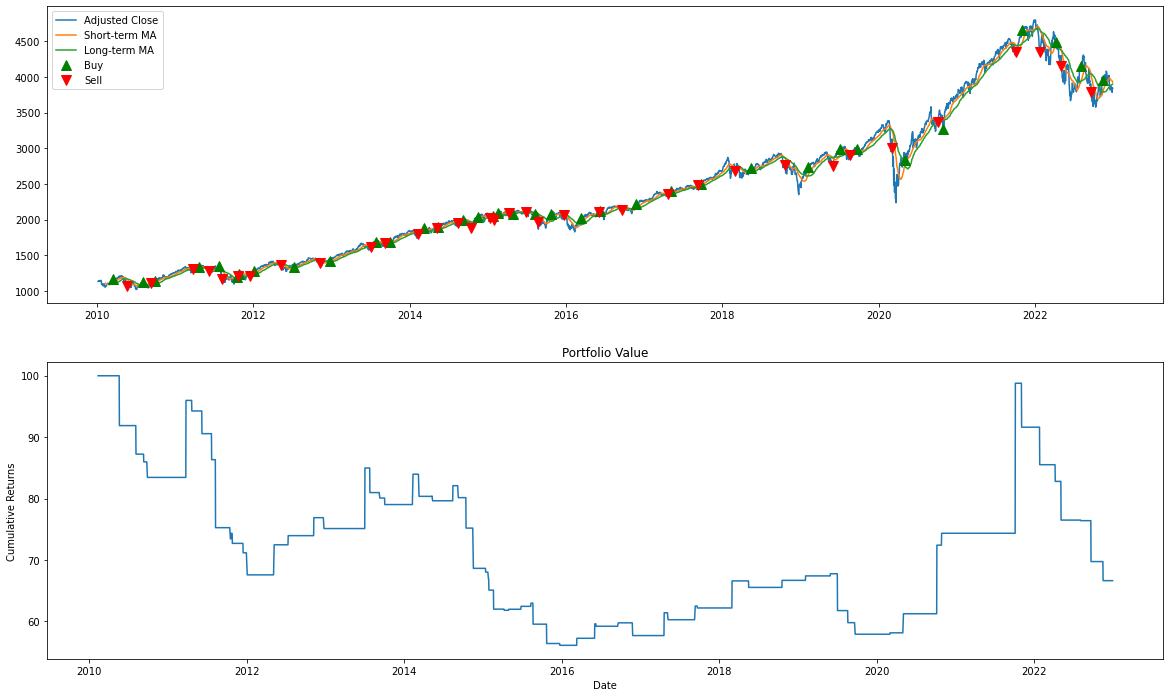

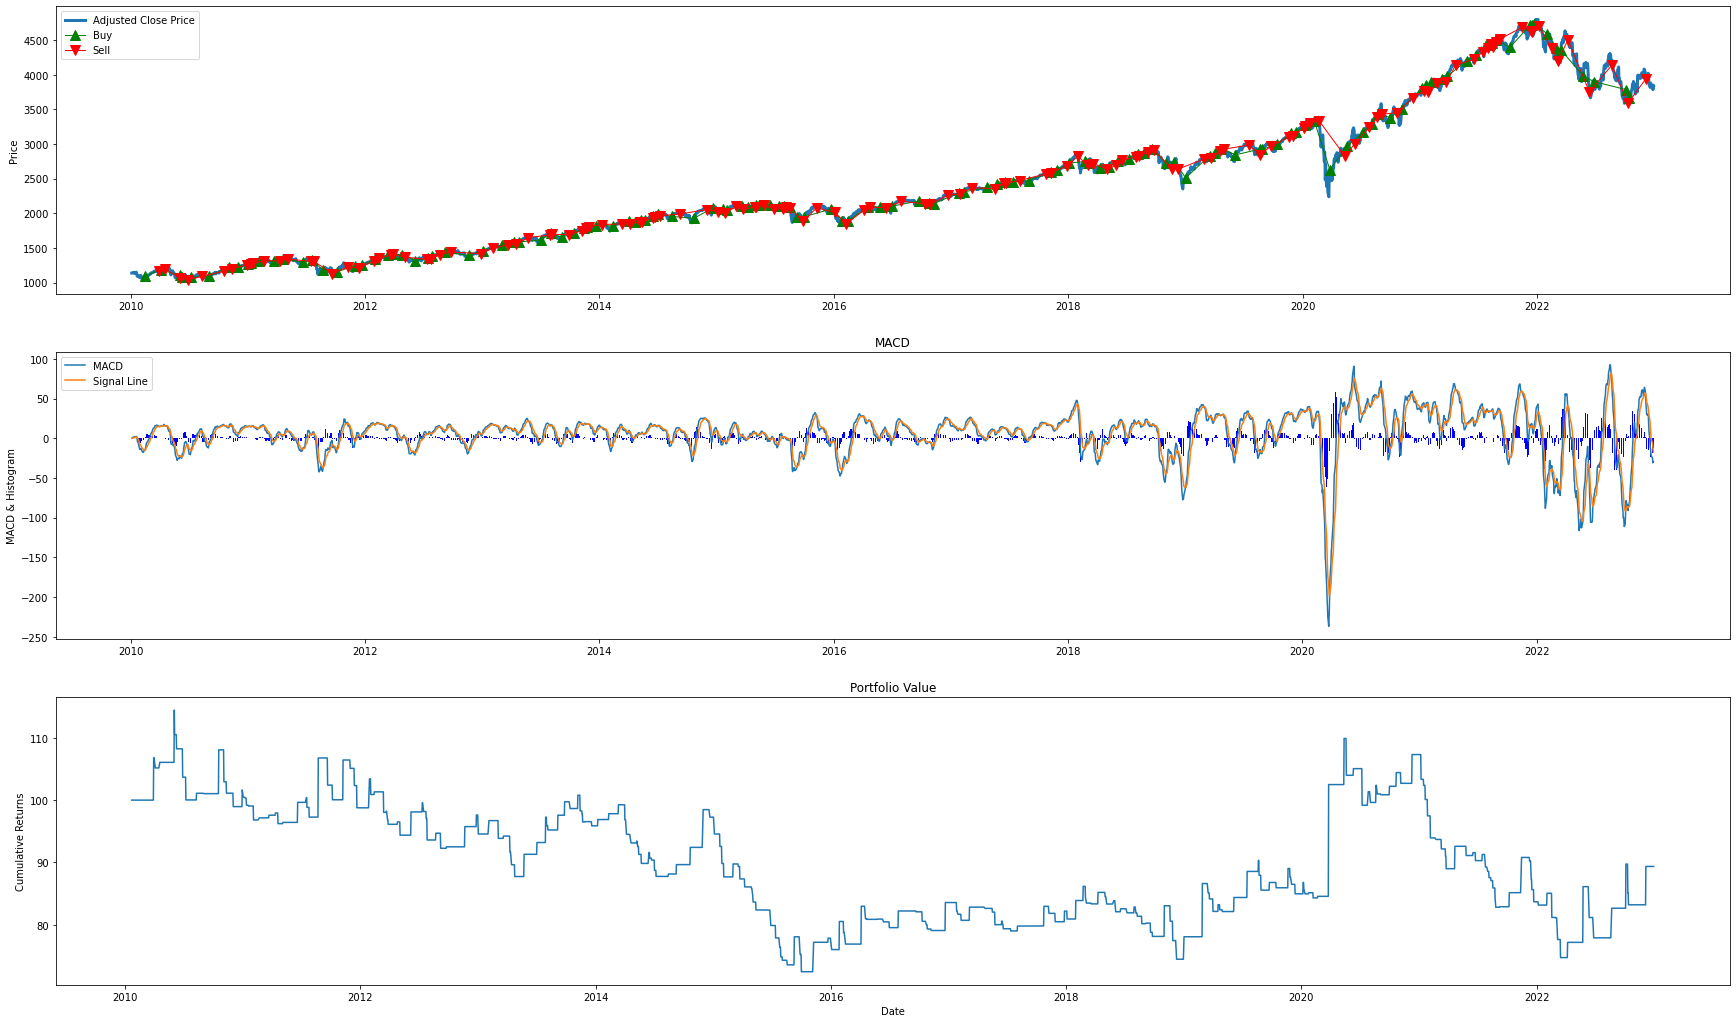

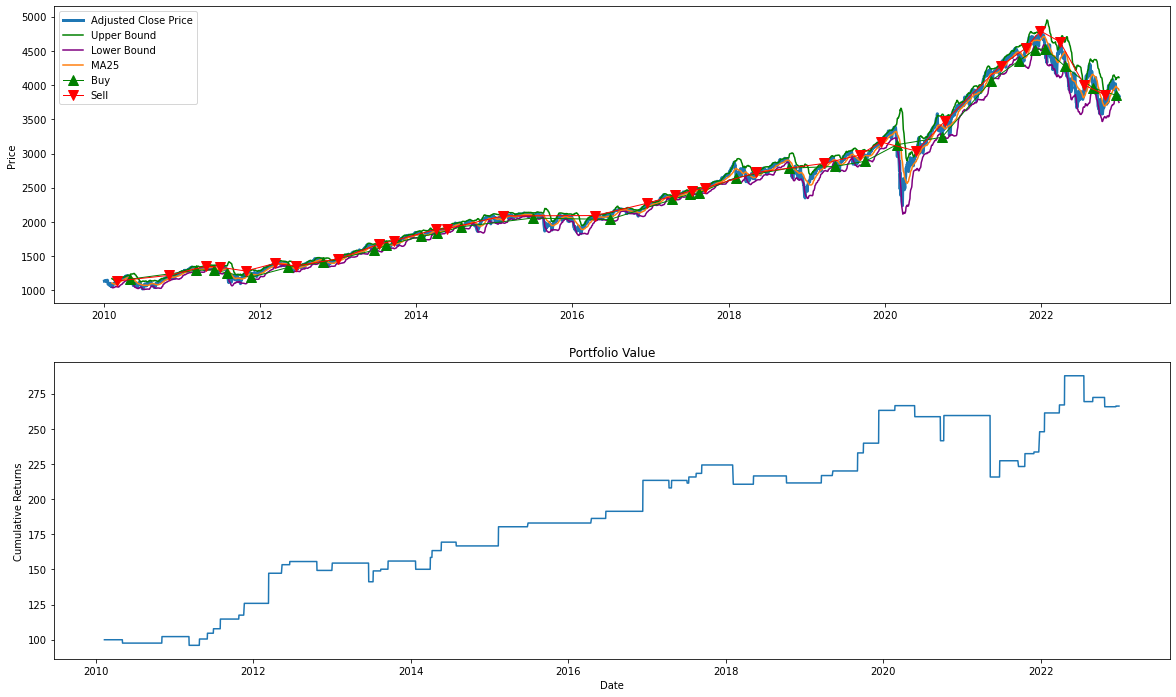

In [392]:
ma_crossover(df,25,50,100) #actual
macd(df,12,26,9,100) #actual
bollinger_bands(df,25,2,100) #actual

# ARIMA In + Out Sample

********************
Initial invesetment: $100
Net Profit: -34.71%
PnL: $-34.71
Current Portfolio: $65.29
market_returns = 0.8255465250860989
market_std = 28.89735617894415
signal_returns = -0.4050141472092871
signal_std = 6.5990289774644575
********************
Initial invesetment: $100
Net Profit: -0.01%
PnL: $-0.01
Current Portfolio: $99.99
market_returns = 0.8255465250860989
market_std = 28.89735617894415
signal_returns = 0.04927009720305215
signal_std = 3.2016329809491504
********************
Initial invesetment: $100
Net Profit: 77.94%
PnL: $77.94
Current Portfolio: $177.94
market_returns = 0.8255465250860989
market_std = 28.89735617894415
signal_returns = 1.3126672494212965
signal_std = 6.747965680744428


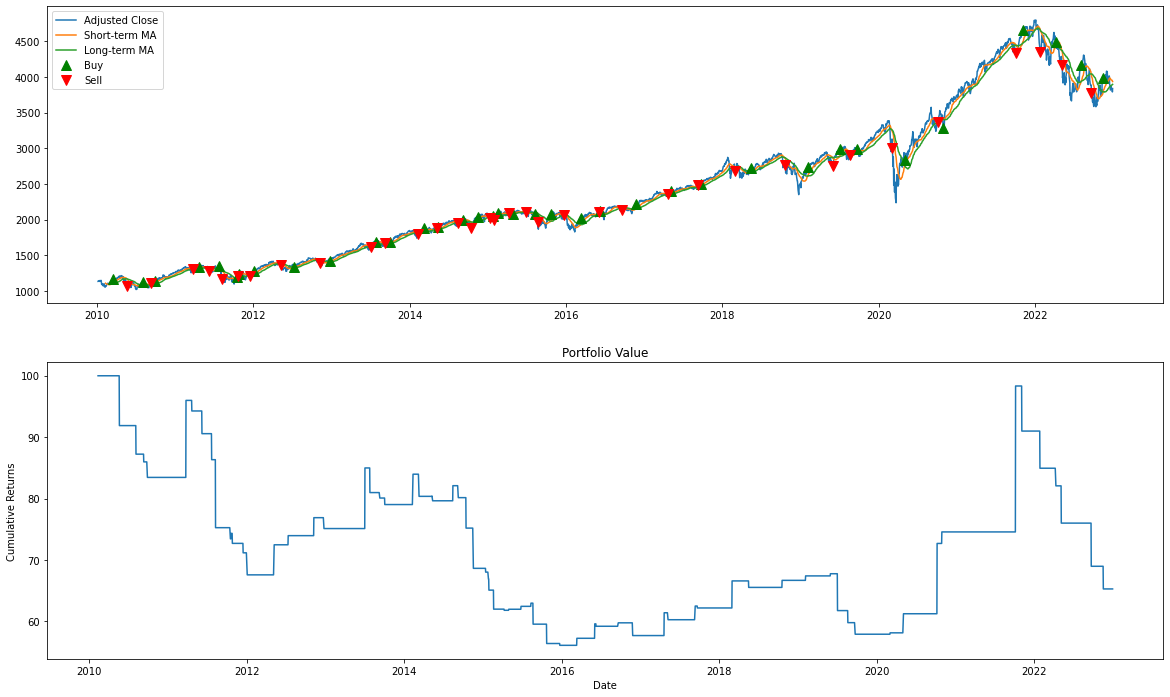

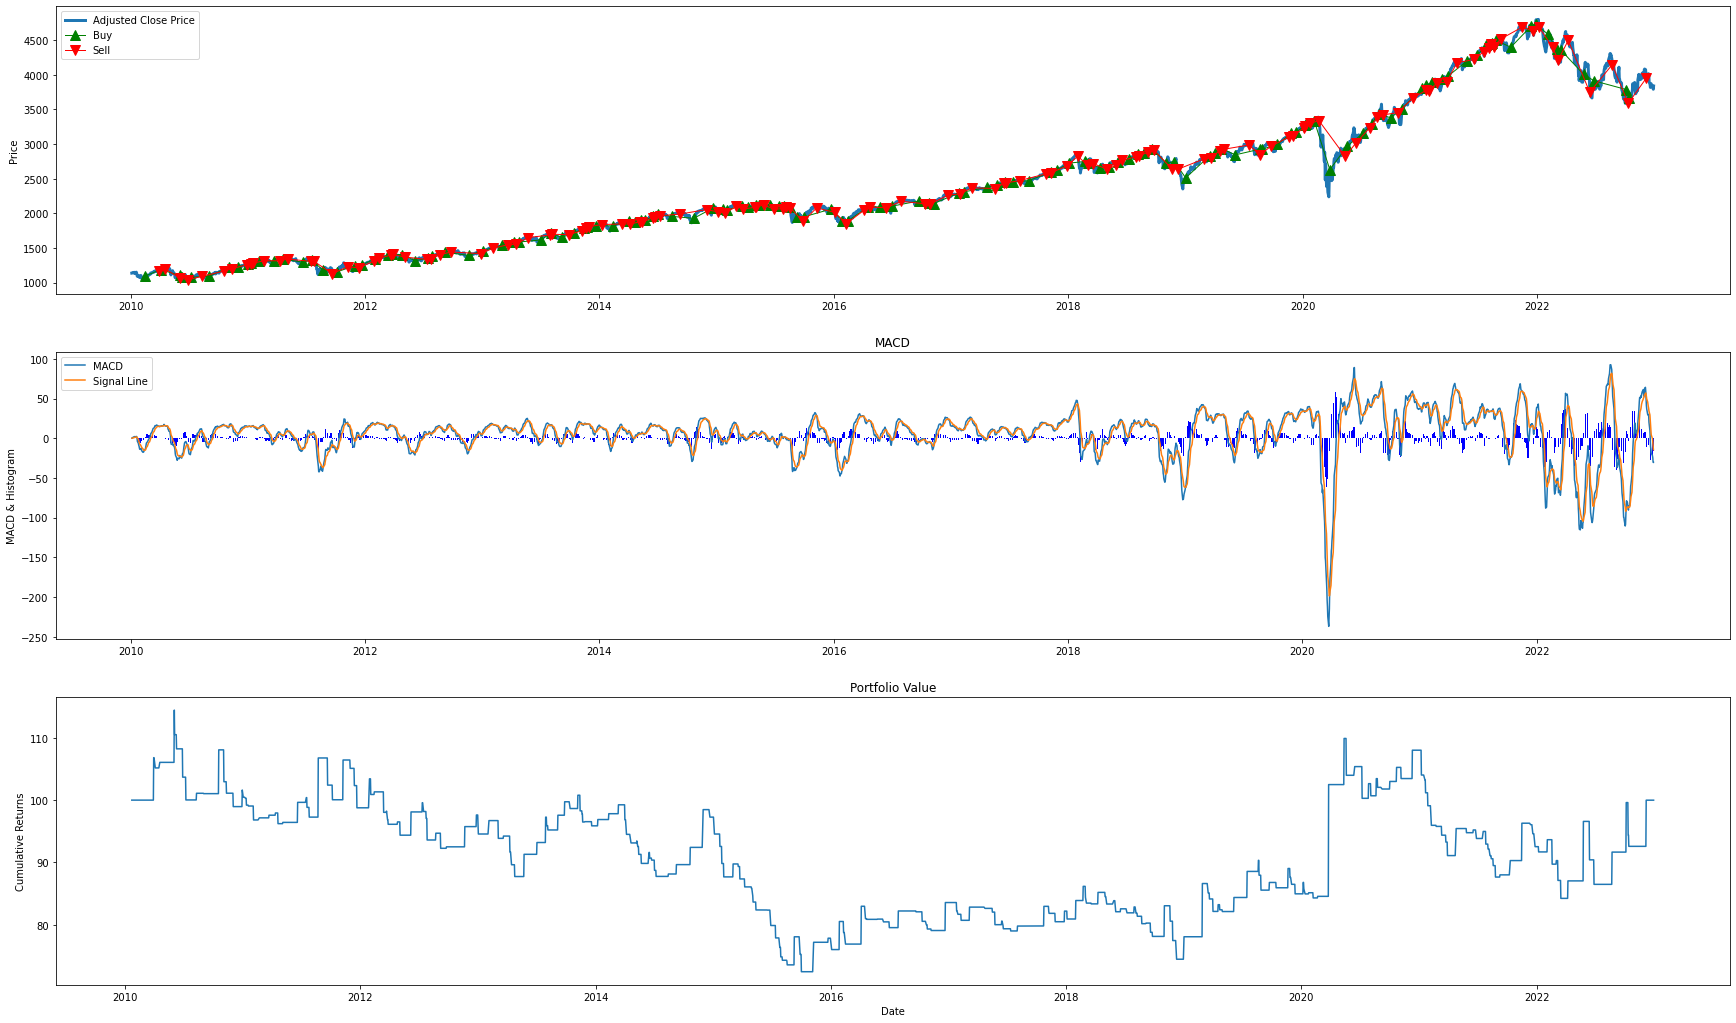

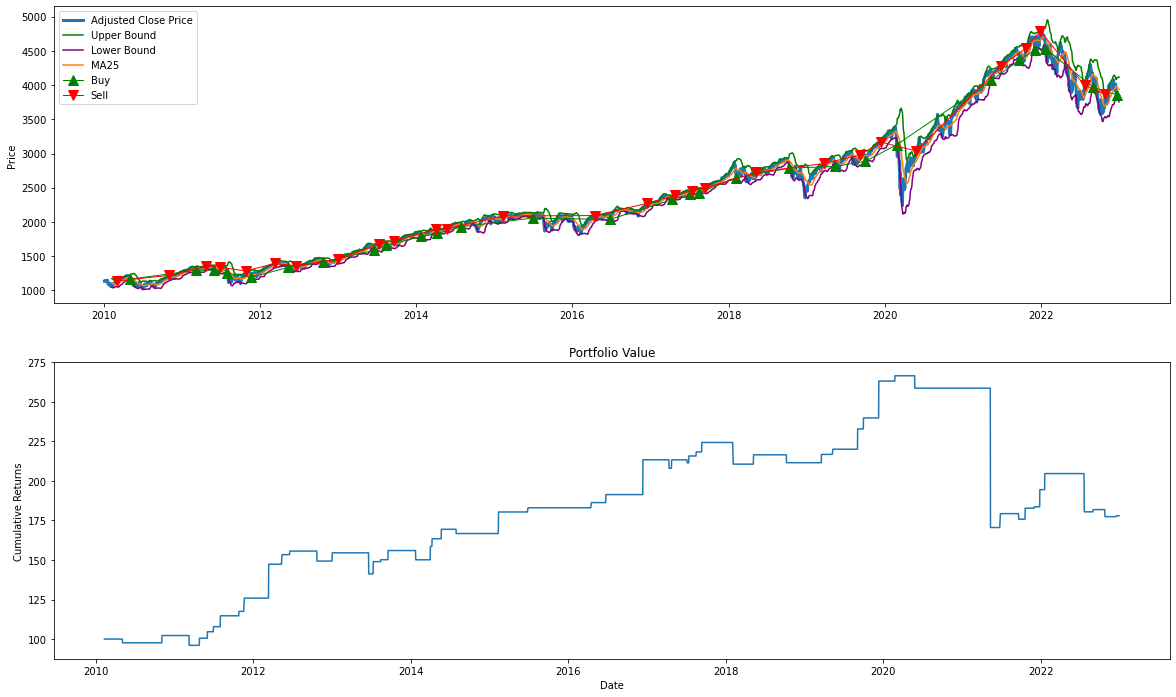

In [393]:
ma_crossover(m1,25,50,100) # predicted
macd(m1,12,26,9,100) #predicted
bollinger_bands(m1,25,2,100) #predicted

# NAIVE In + Out Sample

********************
Initial invesetment: $100
Net Profit: -33.36%
PnL: $-33.36
Current Portfolio: $66.64
market_returns = 0.829590217053708
market_std = 30.11217372251117
signal_returns = -0.37480785222185664
signal_std = 6.631488313604871
********************
Initial invesetment: $100
Net Profit: -10.64%
PnL: $-10.64
Current Portfolio: $89.36
market_returns = 0.829590217053708
market_std = 30.11217372251117
signal_returns = 0.006897573087290405
signal_std = 3.1925788259157817
********************
Initial invesetment: $100
Net Profit: 166.19%
PnL: $166.19
Current Portfolio: $266.19
market_returns = 0.829590217053708
market_std = 30.11217372251117
signal_returns = 1.8098885650430305
signal_std = 5.210925819084555


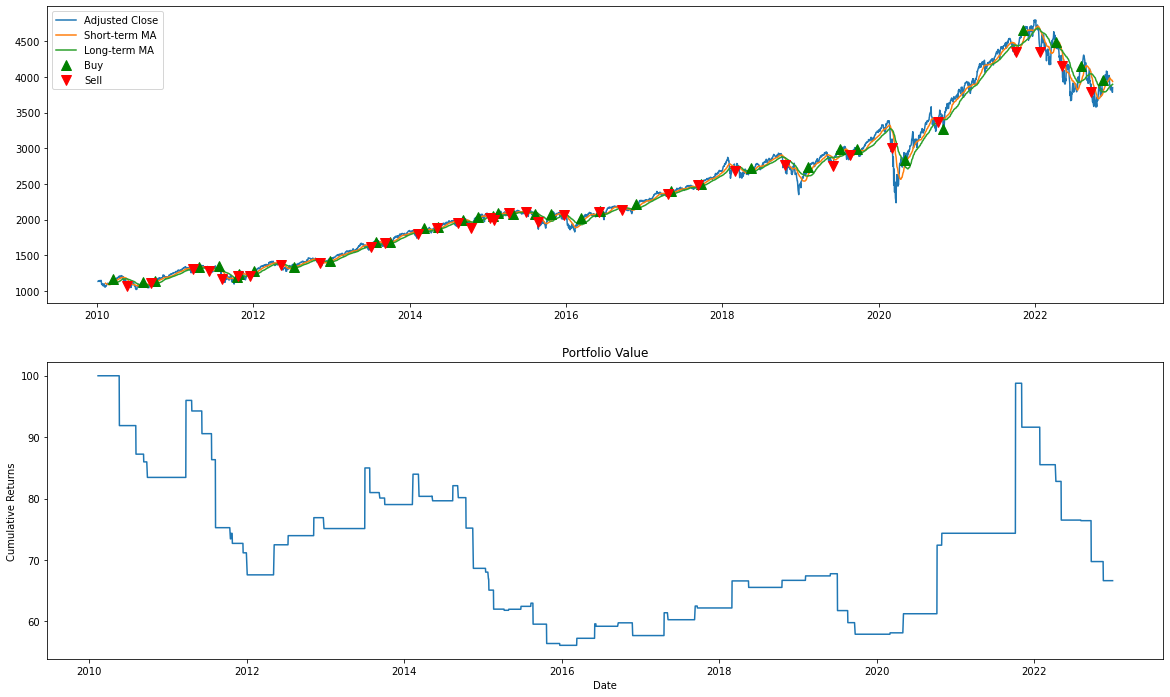

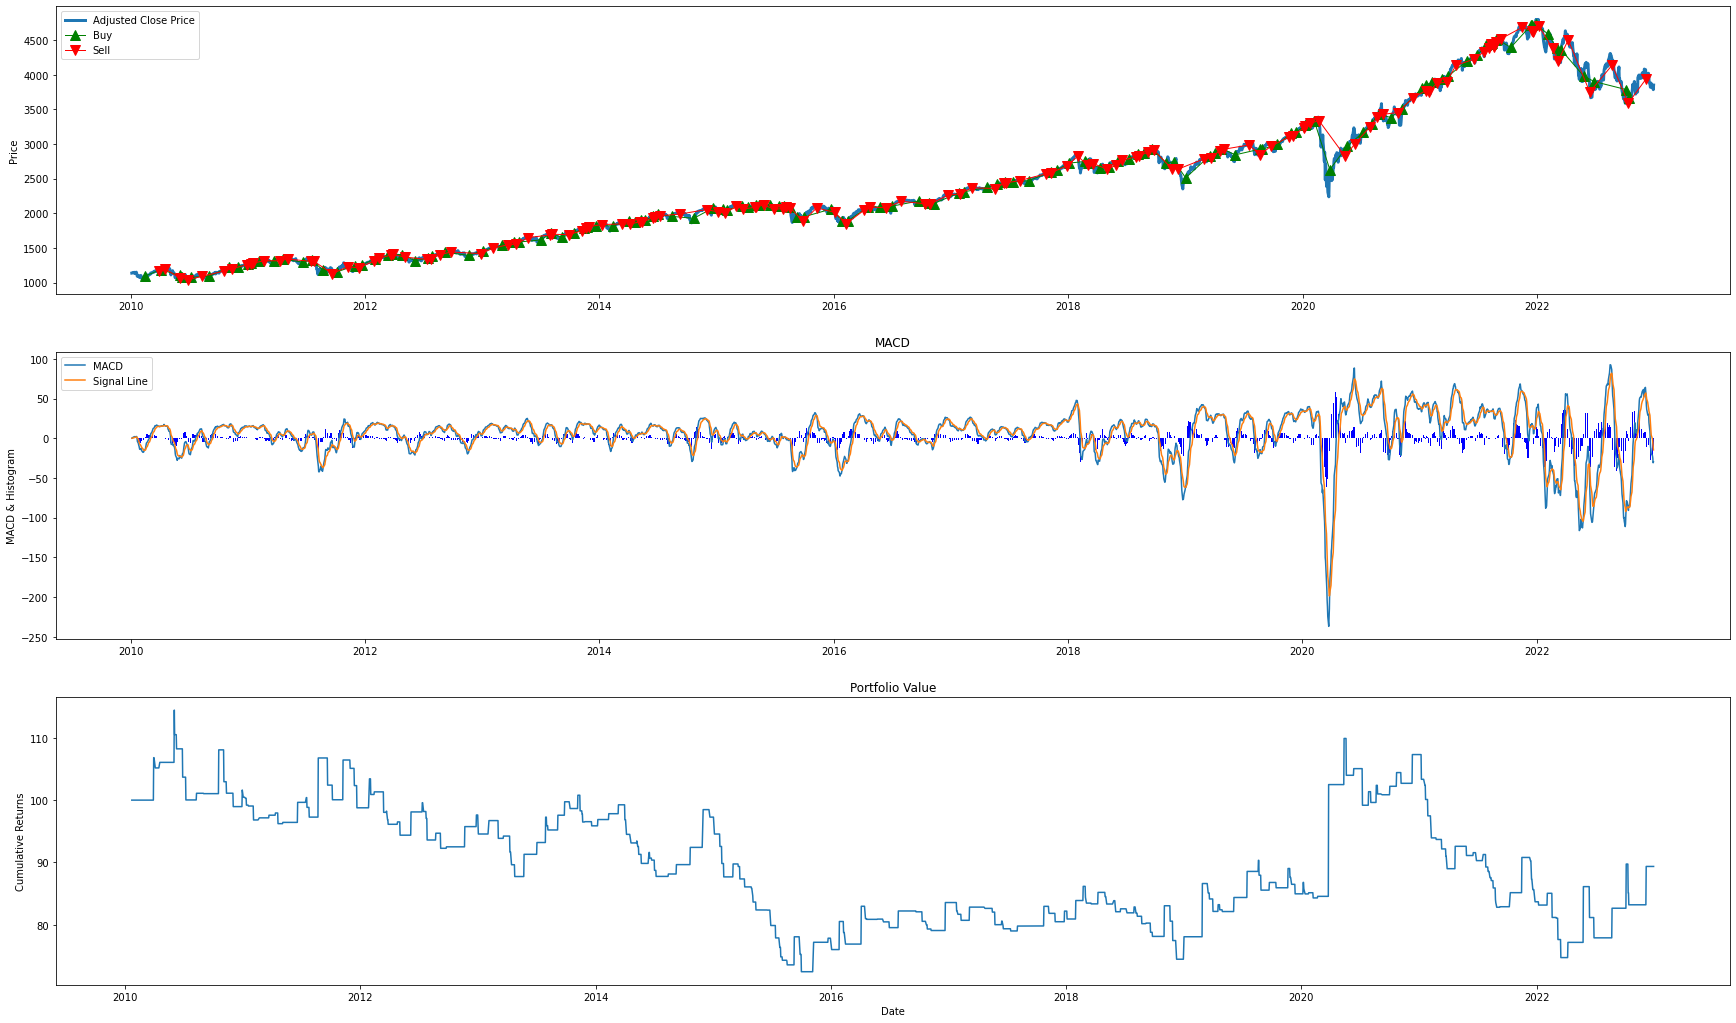

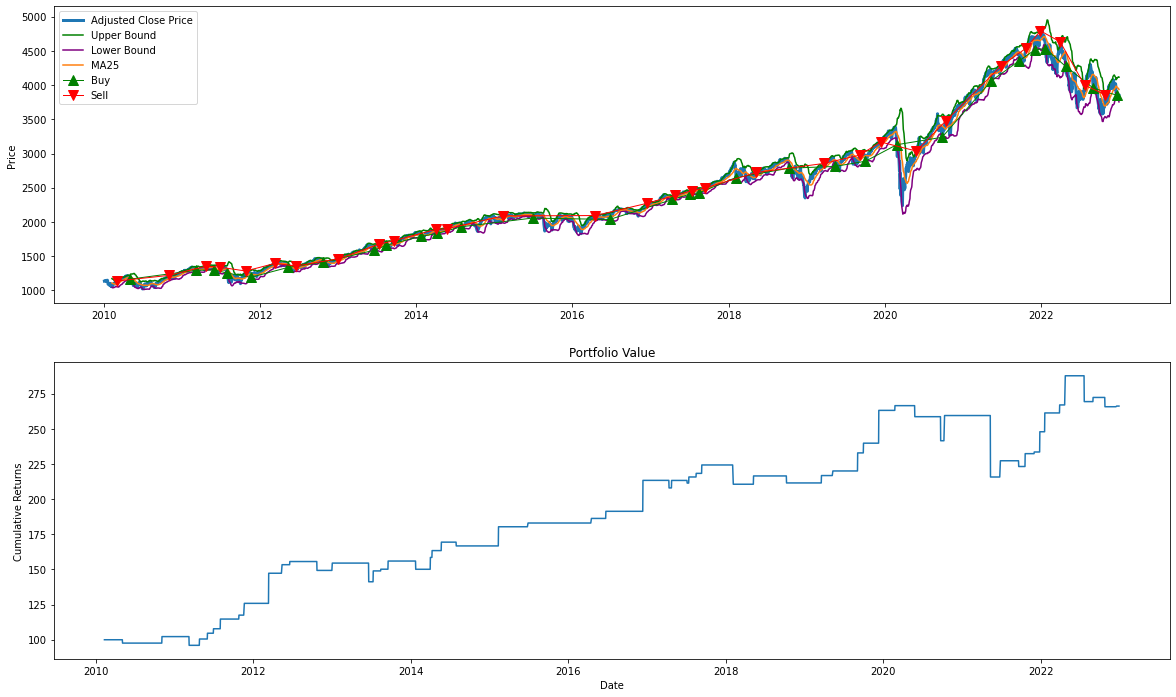

In [394]:
ma_crossover(m2,25,50,100) # predicted
macd(m2,12,26,9,100) #predicted
bollinger_bands(m2,25,2,100) #predicted

# Out sample ARIMA(F1) & NAIVE(F2)

********************
Initial invesetment: $100
Net Profit: -8.90%
PnL: $-8.90
Current Portfolio: $91.10
market_returns = 1.228022970790133
market_std = 44.02939541396725
signal_returns = -0.35944242710239227
signal_std = 11.414328209578924
********************
Initial invesetment: $100
Net Profit: -6.31%
PnL: $-6.31
Current Portfolio: $93.69
market_returns = 1.228022970790133
market_std = 44.02939541396725
signal_returns = -0.06365928874844834
signal_std = 3.5506237280341626
********************
Initial invesetment: $100
Net Profit: -18.20%
PnL: $-18.20
Current Portfolio: $81.80
market_returns = 1.228022970790133
market_std = 44.02939541396725
signal_returns = -1.4573701784703197
signal_std = 7.967687159278224


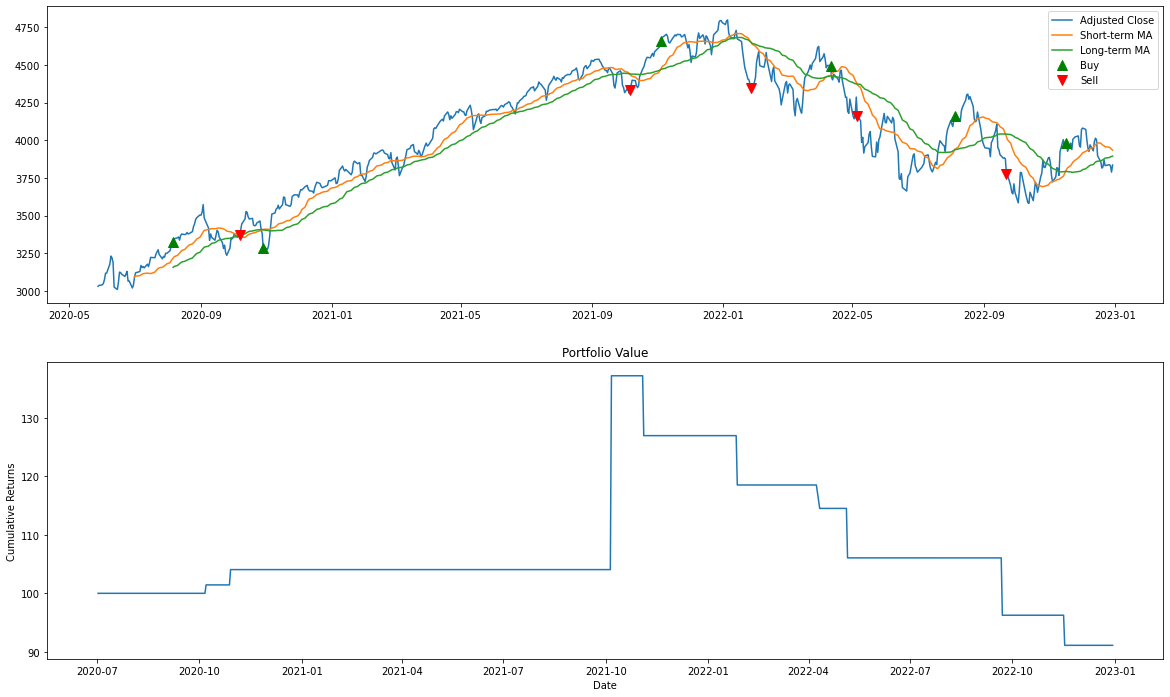

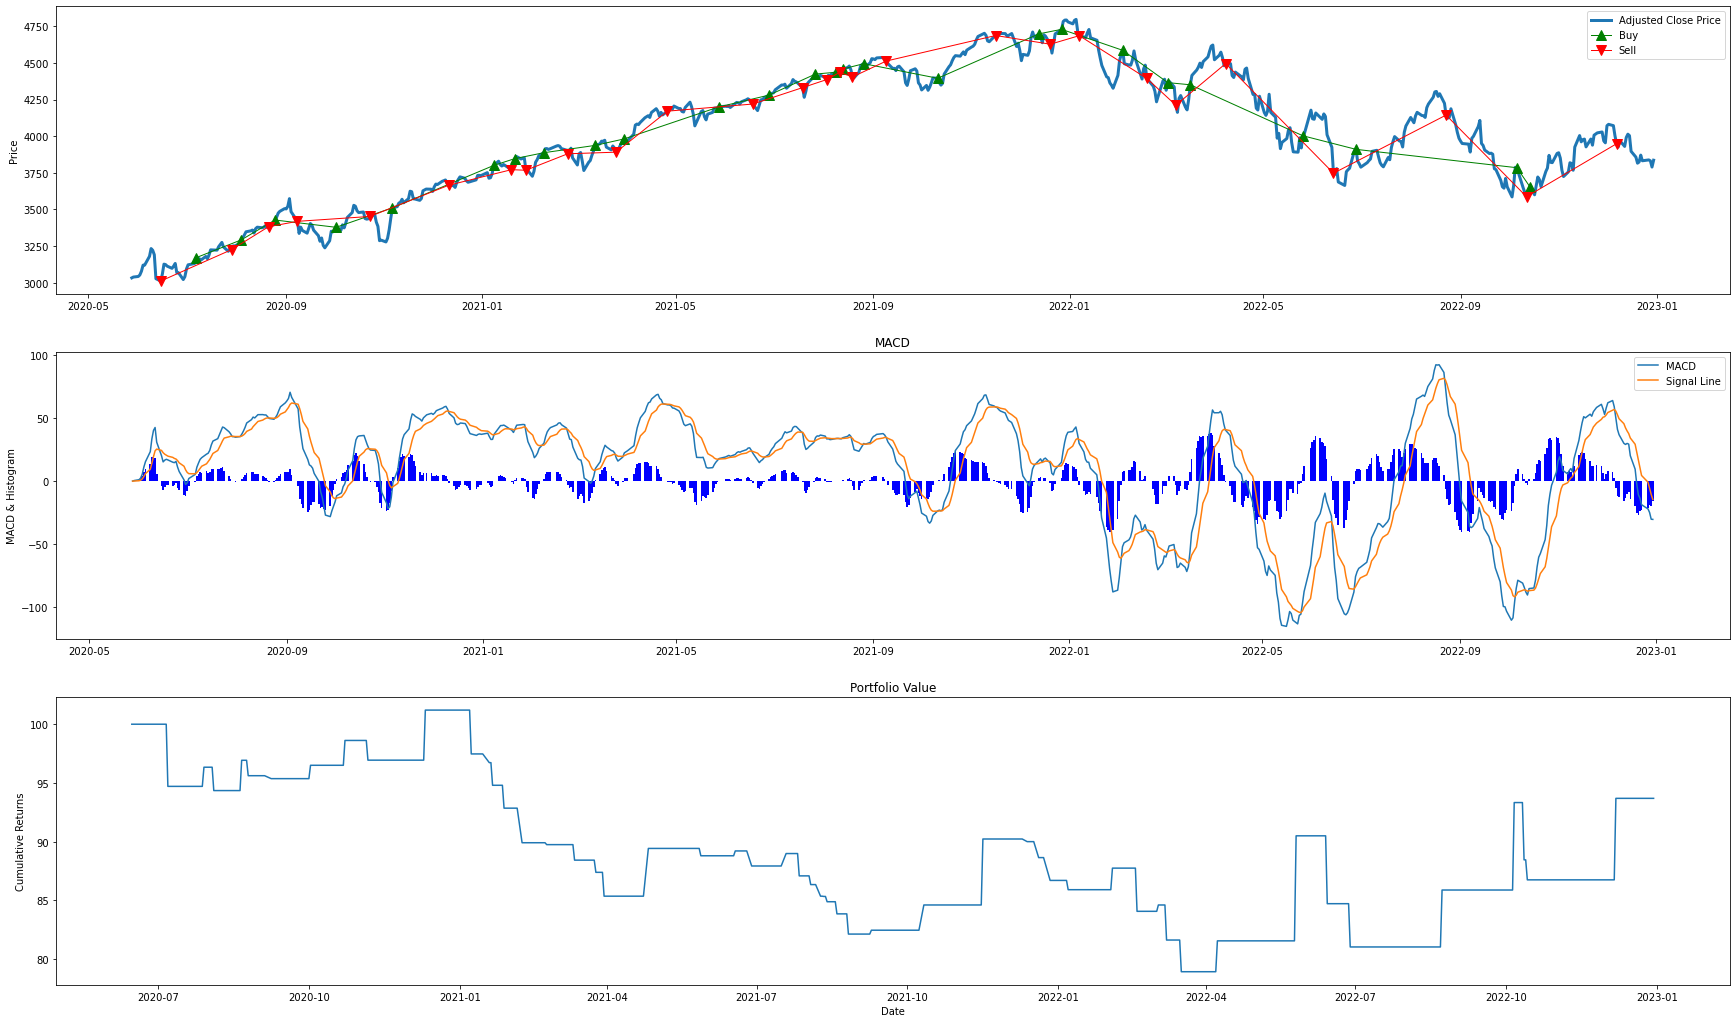

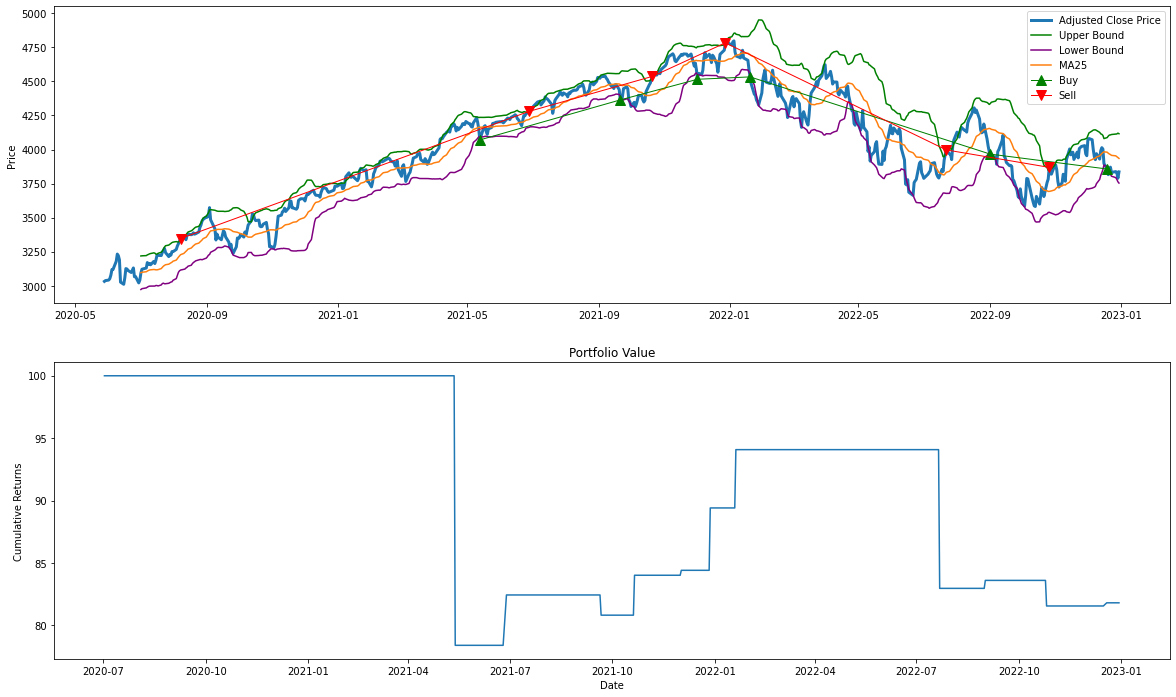

In [398]:
ma_crossover(m1_out,25,50,100) # predicted
macd(m1_out,12,26,9,100) #predicted
bollinger_bands(m1_out,25,2,100) #predicted

********************
Initial invesetment: $100
Net Profit: -7.06%
PnL: $-7.06
Current Portfolio: $92.94
market_returns = 1.2433488478354358
market_std = 47.93190063753623
signal_returns = -0.1465855424334898
signal_std = 11.611034851732903
********************
Initial invesetment: $100
Net Profit: -14.79%
PnL: $-14.79
Current Portfolio: $85.21
market_returns = 1.2433488478354358
market_std = 47.93190063753623
signal_returns = -0.21954082058439628
signal_std = 3.388405807776067
********************
Initial invesetment: $100
Net Profit: 13.90%
PnL: $13.90
Current Portfolio: $113.90
market_returns = 1.2433488478354358
market_std = 47.93190063753623
signal_returns = 1.0703205315226045
signal_std = 6.121608658141916


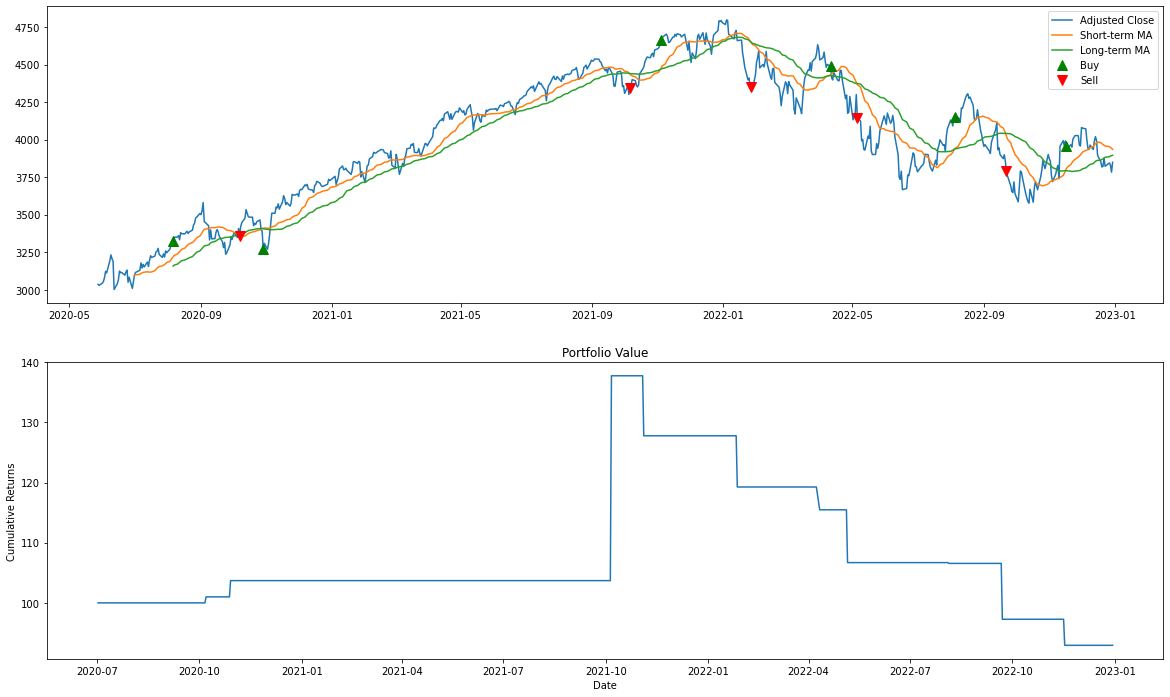

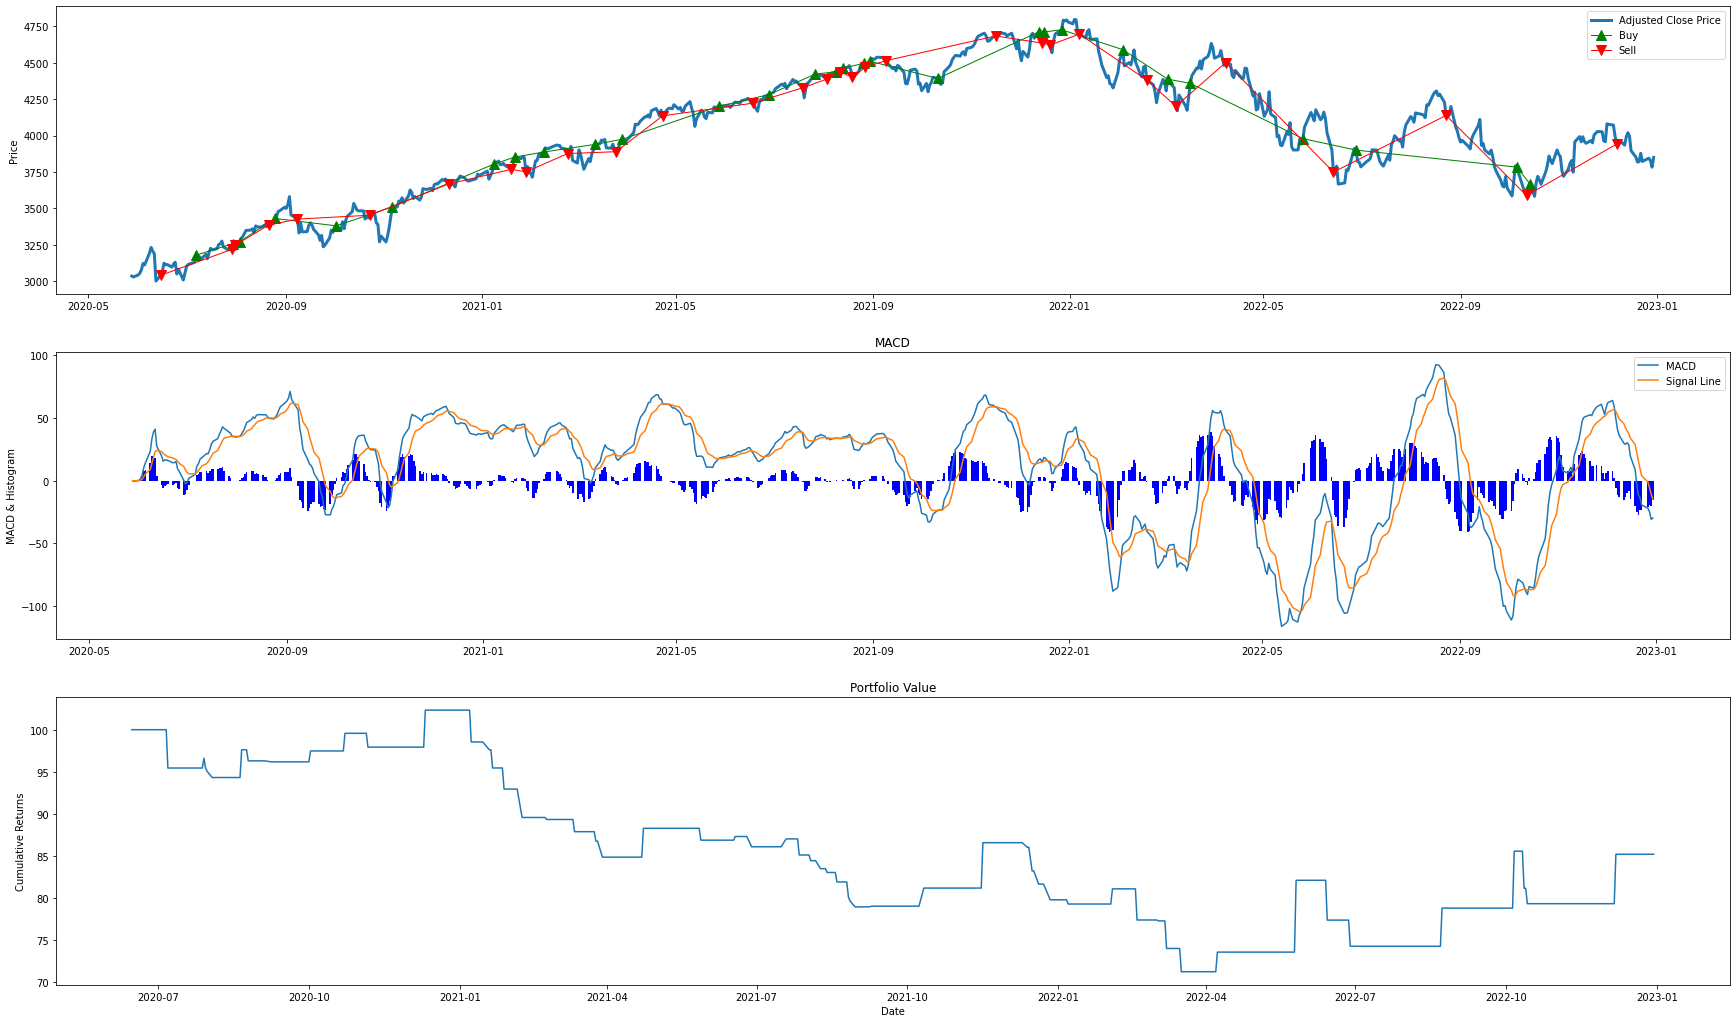

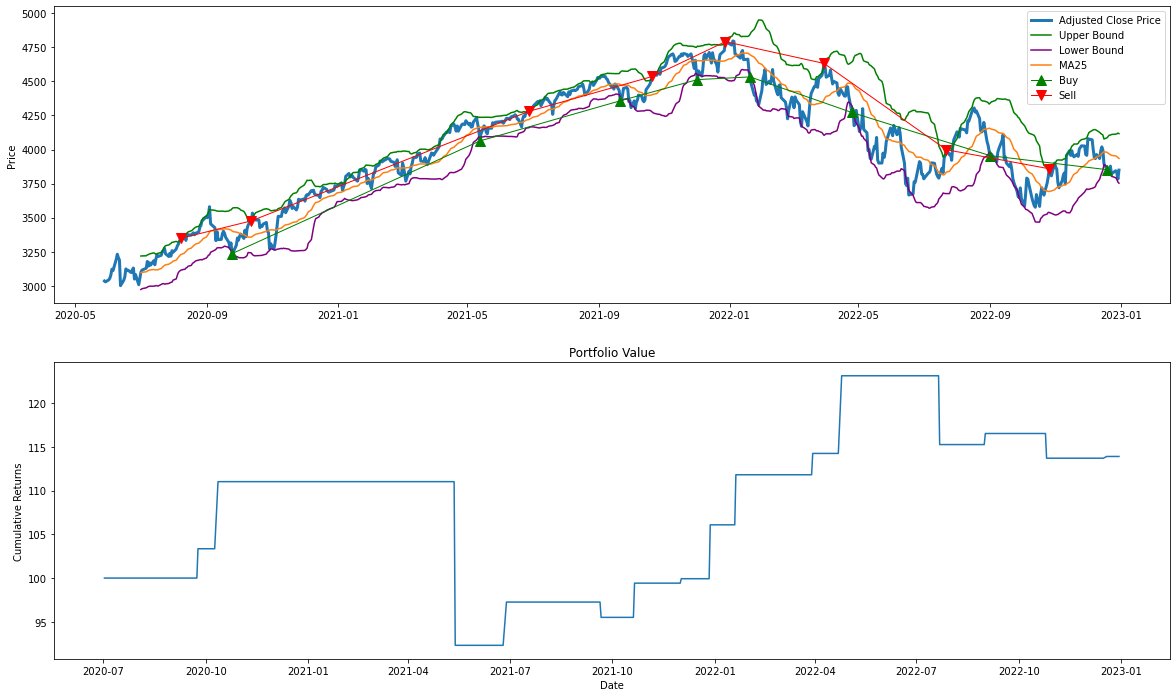

In [396]:
ma_crossover(m2_out,25,50,100) # predicted
macd(m2_out,12,26,9,100) #predicted
bollinger_bands(m2_out,25,2,100) #predicted